COSC2671 Social Media and Network Analytics 

# Assignment 2 - NAME

Lukas Krodinger, s3961415

Note that this notebook requires already downloaded (and pre-processed) twitter posts. This can be done by using the twitterDownloader.ipynb file.

In [42]:
# Used libraries
import codecs
import json
from collections import Counter

import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import TwitterProcessing

nltk.download('vader_lexicon')
nltk.download('stopwords')

from wordcloud import WordCloud
import string
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import warnings

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# There are some warnings with LDA which we want to ignore
warnings.filterwarnings('ignore')

## Introduction - TODO
When one thinks about Australia many beautiful things might come to your mind. The Sydney Opera House, the Uluru, or maybe the Skyline of Melbourne to name just three examples. However, besides the world on land, there is a second world: The underwater world. And Australia can be proud of having the world's largest coral reef, the Great Barrier Reef (= GBR), as part of its coastline in Queensland. The reef is 2.300 km long, it is a natural world wonder and it consists of over 3000 individual reef systems [(1)](https://cairnsdiveadventures.com.au/reef-info/where-is-the-great-barrier-reef-located/) [(2)](https://greatbarrierreef.org/). It is interesting to analyze this topic to find out what various topics the Great Barrier Reef might cover. Therefore, the main task of this analysis is to find out which topics that are.

Before my analysis, I expected that tourism with hotels and boat trips would be a large part of the data. I could also imagine that comparisons of the different reefs (naming the most well-known ones) might be a part of it. It turned out, that these expectations only partly meet the actual Twitter data.

## Data Collection - TODO
For my analysis, I downloaded the Twitter data for one week (ranging from the 2nd of August 2022 to 9th of August 2022) for the search query '"Great Barrier Reef" lang:en'. The query ensures with the usage of '"', that the words 'Great', 'Barrier' and 'Reef' are not only contained in the requested posts but are also in this order contained and the addition 'lang:en' ensures, that only English posts are downloaded. I decided to use only English posts for the reasons of understandability and because the data is enough.

I collected the data with the restful API using [tweepy](https://www.tweepy.org/). The code that was used therefore can be found in the twitterDownloader.ipynb. I decided on the restful API because the data of one week is more than sufficient for this analysis, and because it is not the goal of this report to get real-time (or close to real-time) insights about data but to analyze data of a certain timeframe in the past.

The total number of downloaded tweets is 40709 and before preprocessing this resulted in a file size of 51.79 MB.

## Pre-processing and Data Cleaning - TODO
I decided to first download all public fields of each post and then filter out the relevant fields for this analysis (id, text, entities and created_at) in the next step. Therewith, it is possible to gain access to all other public fields again without downloading the data again. That approach is efficient as for the download of one post it does not matter how many fields are included, it will count as one download to the Twitter rest API limit.

The analysis is based on the text, entities (for hashtags), and created_at fields. Those are the only ones required content-wise. Additionally, I decided to not remove the id, because therewith it is possible to get access to all the data for one specific post again by comparing the ids.
I also filtered that each tweet should contain "great barrier reef" (not case-sensitive) as a part of the text, and I eliminated duplicated tweets that contain exactly the same text as another tweet. I limited the number of tweets to 5000 to not exceed the file size limit of 5 MB.

After pre-processing there are 5.000 tweets left with a file size of 4.81 MB which can be found in the filteredTweets.json file.

Later on in this report, the text field will be further pre-processed when splitting the text into words. This cleaning includes the following tasks:
1. Conversion to lowercase
2. Tokenization
3. Stripping
4. Stemming
5. Removal of stopwords, punctuation, digits, and Twitter specific strings

The conversion to lowercase makes sure that uppercase and lowercase letters are processed the same way. Writing upper- or lowercase letters is relevant for the syntax of the sentence but very little for the semantics. As we are interested in the content we can ignore the upper- and lowercase spelling by converting everything to lowercase.
Tokenization is the process of splitting text into words. To further process the text, this is relevant for our analysis.
Stripping is the process of removing whitespaces at the beginning and the end. Therewith our words now only contain the actual words.
Stemming removes the grammatical context of the words and reduces words to their word stem. Therewith words are reduced to their meaning regardless of the grammatical structure of the sentence. For content analysis, this is what we want to achieve.

All these steps are done in the following process_tweet method:

In [44]:
def process_tweet(text, tokenizer=nltk.tokenize.TweetTokenizer(), stemmer=nltk.stem.PorterStemmer(), stopwords=[]):
    """
    Perform tokenization, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: tweet text
    @param tokenizer: tokenizer used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    @author Jeffrey Chan
    """
    # covert all to lower case
    text = text.lower()

    # tokenize
    tokens = tokenizer.tokenize(text)

    # strip whitespaces before and after
    tokens = [token.strip() for token in tokens]

    # stem (we use set to remove duplicates)
    stemmed_tokens = set([stemmer.stem(tok) for tok in tokens])

    # remove stopwords, digits
    return [tok for tok in stemmed_tokens if tok not in stopwords and not tok.isdigit()]

## Analysis Approach - TODO
To answer the question of what the GBR is about on Twitter, I did mainly three different approaches. I decided to start with word and hashtag analysis, then I did sentiment analysis and at last, I did some topic analysis.

The first part of the analysis, the very simple word and hashtag analysis, is done to get an overview over the topic on Twitter. Additionally, the results of this first part might give us some help for later hyperparameter tuning.

The next part of this report is about sentiment analysis which will be used to understand the feelings (positive or negative sentiment) about the Great Barrier Reef. I considered the scoring based and the Vader approach with and without preprocessing for this report. The count method labels each tweet either positive or negative or neutral. It uses a dictionary with positive associated and a dictionary with negative associated words. The vader method has two main advantages compared to this. Firstly, it considers multiple levels of positivity and negativity resulting in a value ranging from very positive to very negative. Secondly, it tries to consider negated positive words as negative and vice versa. In this report, both were tried out and one can switch between the different methods. The best results however were gained from the vader approach due to its more precise scoring and that is why it is the default approach used later on.

The third and last part is the topic analysis. Here I decided on the Latent Dirichlet Allocation (LDA) due to being a popular and unsupervised approach. LDA is a clustering model, that assumes that each document contains a certain number of topics. Each topic contains words and for each word, there is an assigned probability. It is the probability that the next chosen word out of this topic is the corresponding one. By choosing a number of topics the model is therewith able to generate a sequence of words that depend on the chosen topic and on the probability for each word to be next. By then comparing the generated text to the original text, calculating the difference, adjusting the probabilities, and repeating the model can do unsupervised training. After the training is finished the resulting model can then cluster the tweets to topics that defer from each other. Using this LDA model with a varying number of topics as hyperparameter input I clustered the tweets about the Great Barrier Reef into various topics.

## Analysis & Insights - TODO
In the following you can find my analysis step by step together with the insights I gained from it. I added some helper methods which are used in the following analysis. For an explanation of the code see the comments.

In [45]:
def load_words(filename):
    """
    Loads the worlds of the file with the given name to a set.
    :param filename: The name of the file to load the words from.
    :return: A set of words loaded from the file.
    """
    words = []
    with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            words.append(line.strip())

    return set(words)

In [46]:
def load_tweets(filename):
    """
    Loads the tweets from the file with the given name into an array of tweets.

    @param filename: The filename of the file to load the tweets from.

    @returns: An array of tweets.
    """
    tweets = []
    with open(filename, 'r') as f:
        for sLine in f:
            tweet = json.loads(sLine)
            tweets.append(tweet)
    return tweets

### Words and hashtag analysis
The first real part of this analysis starts with most common words and hashtag analysis to get a good overview of the contents of the tweets.

In [47]:
def get_hashtags(tweet):
    """
    Extracts the associated hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    @author Jeffrey Chan
    """
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])

    return [tag['tag'].lower() for tag in hashtags]

In [48]:
# Name of the json file with the tweets to process
tweets_filename = 'tennis_2022_10_13_10_50.json'

# number of hashtags to display
hashtag_trash = 12

# number of most used words to display
words_trash = 10

# Load the tweets
tweets = load_tweets(tweets_filename)
print(len(tweets))

44552


As a first step of the analysis, get the total number of tweets.

In [66]:
from time import strptime
from datetime import datetime
from time import mktime

# Get the total number of tweets.
print("Total number of tweets: ", len(tweets))

# Get the date range
# first_created_at = tweets[0].get('created_at', '')

first_created_at = tweets[0].get('created_at', '')
for tweet in tweets:
    created_at = tweet.get('created_at', '')
    if created_at is not None or first_created_at < created_at:
        last_created_at = created_at
print("First tweets date: ", first_created_at)

last_created_at = tweets[0].get('created_at', '')
for tweet in tweets:
    created_at = tweet.get('created_at', '')
    if created_at is not None and last_created_at > created_at:
        last_created_at = created_at
print("Last tweets date: ", last_created_at)

first_datetime = datetime.fromtimestamp(mktime(strptime(first_created_at, "%Y-%m-%dT%H:%M:%S.000Z")))
last_datetime = datetime.fromtimestamp(mktime(strptime(last_created_at, "%Y-%m-%dT%H:%M:%S.000Z")))

timediff =  first_datetime - last_datetime
print("Time difference: " + timediff.__str__())

tweets_per_second = len(tweets)/timediff.total_seconds()
print("Tweets per second: " + tweets_per_second.__str__())

seconds_per_week = 604800
estimated_max_timeframe_tweets = int(tweets_per_second * seconds_per_week)
print("Tweet estimation for one week: " + estimated_max_timeframe_tweets.__str__())

Total number of tweets:  44552
First tweets date:  2022-10-07T23:55:11.000Z
Last tweets date:  2022-10-05T23:57:47.000Z
Time difference: 1 day, 23:57:24
Tweets per second: 0.2580570422372049
Tweet estimation for one week: 156072


Good.
rugby:
Tweets per second: 0.21638620610064843
Tweet estimation for one week: 130870

Do not take this one, as there are to many posts
american football OR NFL OR gridiron:
Tweets per second: 30.425963488843813
Tweet estimation for one week: 18401622

Good.
australian football OR AFL OR australian rules football OR footy:
Tweets per second: 0.7975965756520352
Tweet estimation for one week: 482386

Do not take this one, as term "football" not clear
soccer:
Tweets per second: 0.6157509082325896
Tweet estimation for one week: 372406

Good.
cricket OR icc:
Tweets per second: 0.6786562606040041
Tweet estimation for one week: 410451

Might be problematic because of the car.
golf -vw -volkswagen OR LIV:
Tweets per second: 0.63500127000254
Tweet estimation for one week: 384048

Good.
tennis -table:
Tweets per second: 0.2310429277759808
Tweet estimation for one week: 139734

Probably to small.
table tennis OR ping-pong OR whiff-whaff:
Tweets per second: 0.04873888144267089
Tweet estimation for one week: 29477

Good.
basketball OR NBL:
Tweets per second: 0.7111363959607453
Tweet estimation for one week: 430095

Probably to small.
handball:
Tweets per second: 0.117328202179958
Tweet estimation for one week: 70960

Probably to small.
badminton:
Tweets per second: 0.03912133481994406
Tweet estimation for one week: 23660

Acutal data:
badminton:
Total number of tweets:  27450
First tweets date:  2022-10-12T04:40:43.000Z
Last tweets date:  2022-10-05T04:45:18.000Z
Time difference: 6 days, 23:55:25
Tweets per second: 0.04540755138331748

table tennis:
Total number of tweets:  40661
First tweets date:  2022-10-12T05:44:18.000Z
Last tweets date:  2022-10-05T18:14:45.000Z
Time difference: 6 days, 11:29:33

tennis:
Total number of tweets:  44623
First tweets date:  2022-10-12T07:14:38.000Z
Last tweets date:  2022-10-10T05:05:12.000Z
Time difference: 2 days, 2:09:26

tennis2:
Total number of tweets:  44388
First tweets date:  2022-10-10T04:51:50.000Z
Last tweets date:  2022-10-08T00:03:50.000Z
Time difference: 2 days, 4:48:00

tennis3:
Total number of tweets (contains duplicates):  44552
First tweets date:  2022-10-07T23:55:11.000Z
Last tweets date:  2022-10-05T23:57:47.000Z
Time difference: 1 day, 23:57:24

Add download problems in discussion area!

Possible 3:
Focus australia:    Australian Football, Rugby, Cricket
Focus ball and bat: Tennis, Badminton, Cricket, (Baseball)
Focus team:         Basketball, Australian Football, Cricket

Next, we want to find the most used hashtags over all tweets.

In [50]:
# Use a counter for counting hashtags
hashtag_counter = Counter()

# Add hashtags to counter
for tweet in tweets:
    hashtagsInTweet = get_hashtags(tweet)
    hashtag_counter.update(hashtagsInTweet)

# Print most used hashtags
for tag, count in hashtag_counter.most_common(hashtag_trash):
    print(tag + ": " + str(count))

tennis: 3819
etsyseller: 1028
eastvillagebangles: 1010
bracelet: 717
bet: 622
sports: 495
stockingstuffer: 479
テニス: 417
news: 407
usa: 406
jin: 404
football: 393


TODO
The "greatbarrierreef" hashtag is used for obvious reasons. The hashtags "australia", "coral" and "reef" refer to some properties of the GBR.

The third most common hashtag "climatescam" is often used by people who think that the (human made) climate change does not exist. One might not have expected this hashtag with the GBR. Also, the hashtag "auspol", which refers to australian politics, is not the first thing that one would expect when thinking of the GBR. The hashtags "climatechange", "climate", "environment", "climatecrisis" and "climateemergency" show that the GBR is also an interesting topic when it comes to climate change in general.

The conclusions from this first simple analysis already show that the GBR on Twitter is less about tourism, snorkeling or diving as much more about the climate and politics.

I continue with a simple analysis by having a look at the most common words.

In [51]:
# Tweet tokenizer to use
tweet_tokenizer = nltk.tokenize.TweetTokenizer()

# Use the punctuation symbols defined in string.punctuation
puncts = list(string.punctuation)

# Use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
twitter_stopwords = ['rt', 'via', '...', '…', '"', "'", '`', '‘', '“', '”']
web_stopwords = ["gbr", 'ha', 'us', 'wa', 'https', 'thi', 'co']
all_stopwords = nltk.corpus.stopwords.words('english')\
                + twitter_stopwords\
                + web_stopwords \
                + puncts
stopwords = list(dict.fromkeys(all_stopwords))

# Use the popular Porter stemmer
tweet_stemmer = nltk.stem.PorterStemmer()

# The term frequency counter
word_counter = Counter()

In [52]:
tweet_text_processed = []
# for tweet in tweets[0:1000]:
for tweet in tweets:
    tweet_text = tweet.get('text', '')

    # Tokenize, filter stopwords and get convert to lower case
    tokens = process_tweet(text=tweet_text, tokenizer=tweet_tokenizer, stemmer=tweet_stemmer, stopwords=stopwords)
    tweet_text_processed.append(' '.join(tokens))

    # Update counter
    word_counter.update(tokens)

# Print out most common terms
for term, count in word_counter.most_common(words_trash):
    print(term + ': ' + str(count))

tenni: 31605
🎾: 4698
play: 4156
’: 4029
#tenni: 3712
️: 2933
girl: 2878
player: 2543
de: 2179
like: 2000


TODO
Here we can ignore "great", "barrier" and "reef", as those are obvious for the chosen topic. In the other words, we again can see a similar trend as with the hashtags. There are some expected common words, such as "coral", "cover", or "australia", but there are also some which one might not expect with the GBR:

- "cover", "highest", and "record" might refer to some news about a new positive record
- "climate" might refer to global warming/climate change

To find out more about what the tweets are about and which topics exist among them, we will have a look at topic analysis later on. For now, let's continue with sentiment analysis.

### Sentiment Analysis - TODO
The goal of this part of the analysis is to find out how people think about the GBR or, in other words, whether they have a positive or negative sentiment towards it. For this part of the analysis I expected, that most people would have a very positive sentiment (as I didn't expect the topic to be controversial) and therewith that the overall sentiment is always positive.

In [53]:
def count_words(tweet_words, words_to_count):
    """
    Counts the tweet_words but only if the word is one of the words_to_count.
    :param tweet_words: The words where each word is counted or not.
    :param words_to_count: The words which get counted.
    :return: The number of counted words.
    """
    word_count = 0
    for word in tweet_words:
        if word in words_to_count:
            word_count += 1
    return word_count


def count_word_sentiment_analysis(pos_words, neg_words, tweet_filename, tweet_processor):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param pos_words: set of positive sentiment words
    @param neg_words: set of negative sentiment words
    @param tweet_filename: name of input file containing a json formated tweet dump
    @param tweet_processor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    @author Jeffrey Chan
    """
    sentiments = []
    # open file and process tweets, one by one
    with open(tweet_filename, 'r') as f:

        # Note that this is using the older data format, but same ideas still apply
        for line in f:
            # each line is loaded according to json format, into tweet, which is actually a dictionary
            tweet = json.loads(line)

            try:
                tweet_text = tweet.get('text', '')
                tweet_date = tweet.get('created_at')
                # pre-process the tweet text
                tokens = tweet_processor.process(tweet_text)

                # Compute sentiment value
                number_pos_words = count_words(tokens, pos_words)
                number_neg_words = count_words(tokens, neg_words)
                sentiment =  number_pos_words - number_neg_words

                # save the date and sentiment of each tweet (used for time series)
                sentiments.append([pd.to_datetime(tweet_date), sentiment])

            except KeyError as e:
                pass

    return sentiments


def vader_sentiment_analysis(tweet_filename, tweet_processor, preprocess_words=True):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param tweet_filename: name of input file containing a json formatted tweet dump
    @param tweet_processor: TweetProcessing object, used to pre-process each tweet.
    @param preprocess_words: Whether the words should be preprocessed before analysis or not.

    @returns: list of tweets, in the format of [date, sentiment]
    @author Jeffrey Chan

    """
    # this is the vader sentiment analyser, part of nltk
    sent_analyser = SentimentIntensityAnalyzer()

    sentiments = []
    # open file and process tweets, one by one
    with open(tweet_filename, 'r') as f:
        for line in f:
            # each line is loaded according to json format, into tweet, which is actually a dictionary
            tweet = json.loads(line)

            try:
                tweet_text = tweet.get('text', '')
                tweet_date = tweet.get('created_at')

                # pre-process the tweet text
                if preprocess_words:
                    tokens = tweet_processor.process(tweet_text)
                else:
                    tokens = tweet_text

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see lab sheet for what dSentimentScores holds
                if preprocess_words:
                    sentiment_scores = sent_analyser.polarity_scores(" ".join(tokens))
                else:
                    sentiment_scores = sent_analyser.polarity_scores(tokens)

                # save the date and sentiment of each tweet (used for time series)
                sentiments.append([pd.to_datetime(tweet_date), sentiment_scores['compound']])

            except KeyError as e:
                pass

    return sentiments

In [54]:
# input file of set of positive words - provided by Jeffrey Chan
pos_words_filename = 'positive-words.txt'

# input file of set of negative words - provided by Jeffrey Chan
neg_words_filename = 'negative-words.txt'

# specify the approach to take, one of [count, vader_preprocess, vader]
# change this to use a different sentiment approach, default is 'count'
approach = 'vader_preprocess'

In [55]:
# call the TwitterProcessing python script
tweet_processor = TwitterProcessing.TwitterProcessing(tweet_tokenizer, stopwords)

pos_words = load_words(pos_words_filename)
neg_words = load_words(neg_words_filename)

In [56]:
# compute the sentiment
# to change method, update parameter settings, particularly the variable 'approach' and rerun the parameter setting cell,
# and also this cell
sentiments = []
if approach == 'count':
    sentiments = count_word_sentiment_analysis(pos_words, neg_words, tweets_filename, tweet_processor)
elif approach == 'vader_preprocess':
    sentiments = vader_sentiment_analysis(tweets_filename, tweet_processor, True)
elif approach == 'vader':
    sentiments = vader_sentiment_analysis(tweets_filename, tweet_processor, False)

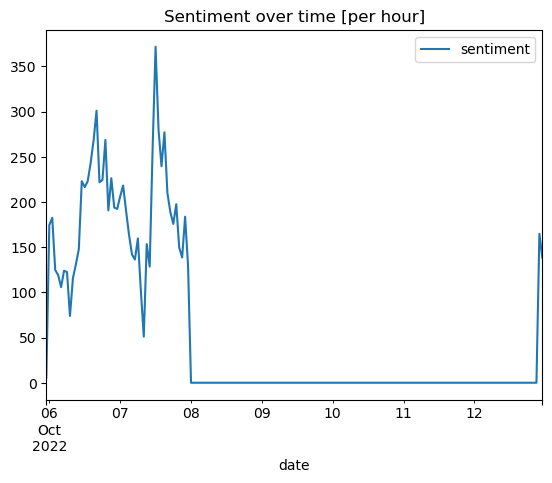

In [57]:
# Visualize the gathered data
series = pd.DataFrame(sentiments, columns=['date', 'sentiment'])
series.set_index('date', inplace=True)
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

series = series.resample('1H').sum()
series.plot()
plt.title("Sentiment over time [per hour]")
plt.show()

TODO
So indeed the sentiment seems to be positive all the time over the week. However, there is an interesting thing about this data anyway:

The sentiment goes down from the 4th of August onwards. After some research, I found out, that this is probably because the good news that the GBR is recovering was released around this date by [CNBC](https://www.cnbc.com/2022/08/04/great-barrier-reef-areas-show-highest-coral-cover-seen-in-36-years.html). From there on the sentiment stays positive overall but is not as positive anymore as before. The good news flattens off and some basic positive sentiment stays.

To find out what the topics are about, we next will do some topic analysis.

### Topic analysis - TODO
In this third part of the analysis, we want to find out in what groups of topics the tweets can be grouped. One very important parameter for the used algorithm LDA is the number of topics the tweets should be grouped into. Because this is the most interesting analysis for the GBR, I decided to spend some time and try out different configurations. While I tried configurations with 4, 5, 6, 8, 10, and 15 topics I decided to only show the configurations with 5 and 10 here.

In [58]:
def display_topics(model, feature_names, words_to_print_per_topic):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param feature_names: list of strings, representing the list of features/words.
    @param words_to_print_per_topic: number of words to print per topic.
    @author Jeffrey Chan
    """

    # print out the topic distributions
    for topic_id, topic_distribution in enumerate(model.components_):
        print("Topic %d:" % (topic_id+1))
        print(" ".join([feature_names[i] for i in topic_distribution.argsort()[:-words_to_print_per_topic - 1:-1]]))

def display_word_crowd(model, feature_names):
    """
    Displays the word cloud of the topic distributions of the model.

    @param model: The LDA model.
    @param feature_names: list of strings, representing the list of features/words.
    """

    # normalize each row/topic to sum to one
    normalised_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # Display a wordcrowd for each topic
    for topic_id, topic_distribution in enumerate(normalised_components):
        word_probabilities = {feature_names[i] : wordProb for i, wordProb in enumerate(topic_distribution)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=word_probabilities)
        plt.title('Topic %d:' % (topic_id+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show(block=True)

In [59]:
# number of topics to discover (default = 10)
number_of_topics = 5

# maximum number of words to display per topic (default = 10)
words_to_display_per_topic = 10

# number of features/words to describe our documents
number_of_features = 1500
# extract a document-term matrix and the feature names using a CountVectorizer to do counting
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=number_of_features, stop_words=stopwords)
document_term_matrix = vectorizer.fit_transform(tweet_text_processed)

# extract the names of the features (= words)
feature_names = vectorizer.get_feature_names_out()

In [60]:
# train LDA model with the data
lda_model = LatentDirichletAllocation(n_components=number_of_topics, max_iter=10, learning_method='online').fit(document_term_matrix)

In [61]:
# Print the most common words per topic.
display_topics(lda_model, feature_names, words_to_display_per_topic)

Topic 1:
tenni bracelet gift feel becaus give silver etsysel eastvillagebangl sterl
Topic 2:
tenni de vs la le un atp wta en et
Topic 3:
tenni play like player court thank ball amaz second get
Topic 4:
tenni team bet girl today time odd play follow tournament
Topic 5:
tenni new djokov novak player open first match 10 sport


In [62]:
# Visualize using pyLDAvis
panel = pyLDAvis.sklearn.prepare(lda_model, document_term_matrix, vectorizer, mds='tsne')
pyLDAvis.display(panel)

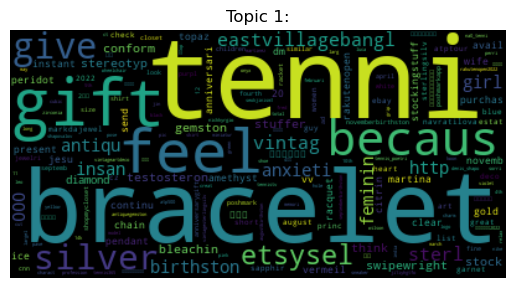

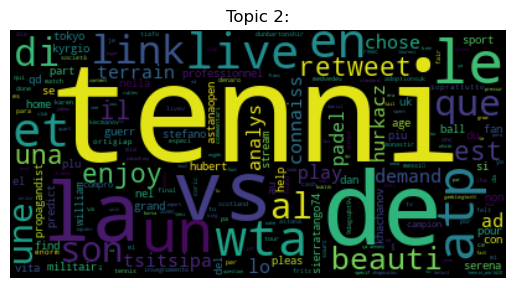

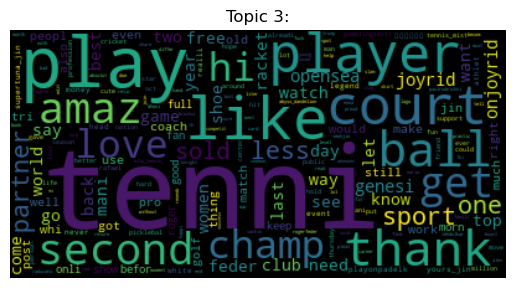

KeyboardInterrupt: 

In [63]:
# Display the wordclouds
display_word_crowd(lda_model, feature_names)

In [ ]:
# number of topics to discover (default = 10)
number_of_topics = 10

# train LDA model with the data
lda_model = LatentDirichletAllocation(n_components=number_of_topics, max_iter=10, learning_method='online').fit(document_term_matrix)

In [ ]:
# Print the most common words per topic.
display_topics(lda_model, feature_names, words_to_display_per_topic)

Topic 1:
tenni bet second follow footbal new inplayfe break take join
Topic 2:
tenni open djokov odd novak less sold opensea genesi onjoyrid
Topic 3:
tenni play ball like thank sport amaz get partner go
Topic 4:
court tenni feel becaus give girl insan feminin anxieti swipewright
Topic 5:
tenni de la le un champ en et que club
Topic 6:
tenni team girl today vs match win tournament start boy
Topic 7:
tenni player game one http wta atp hi love 10
Topic 8:
tenni 000 look octob week next talk una still avail
Topic 9:
tenni play great women onli think watch two say let
Topic 10:
bracelet tenni gift silver etsysel eastvillagebangl sterl antiqu birthston vintag


In [ ]:
# Visualize using pyLDAvis
panel = pyLDAvis.sklearn.prepare(lda_model, document_term_matrix, vectorizer, mds='tsne')
pyLDAvis.display(panel)

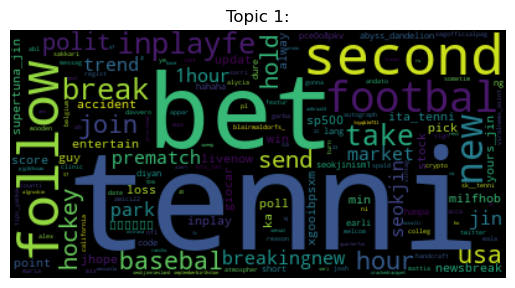

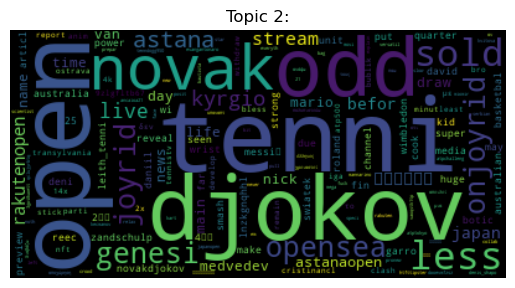

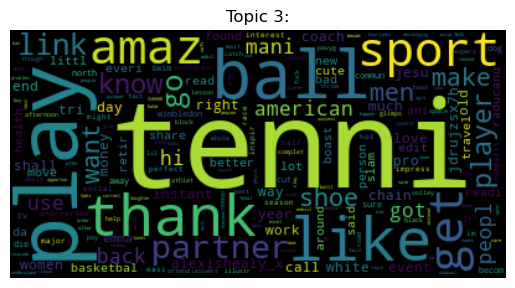

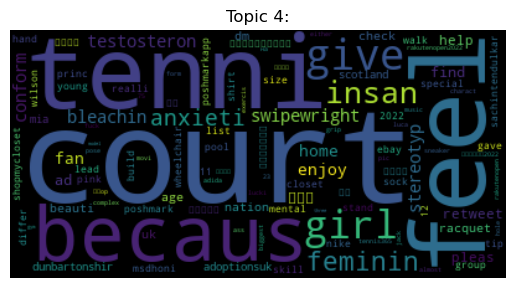

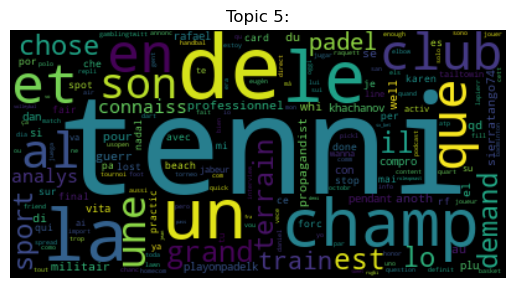

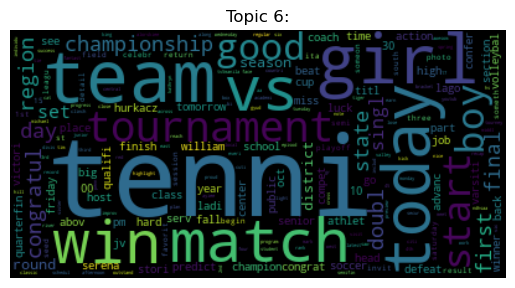

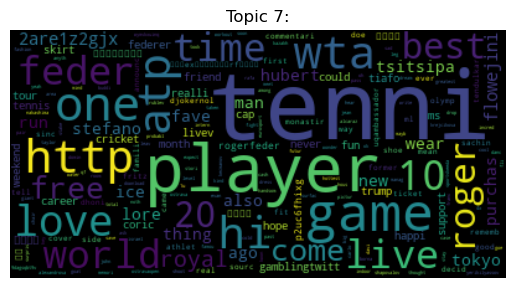

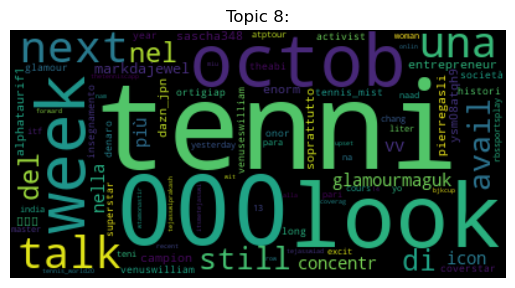

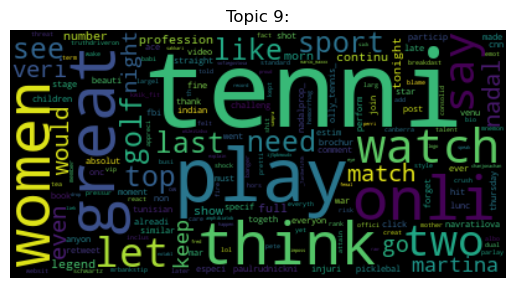

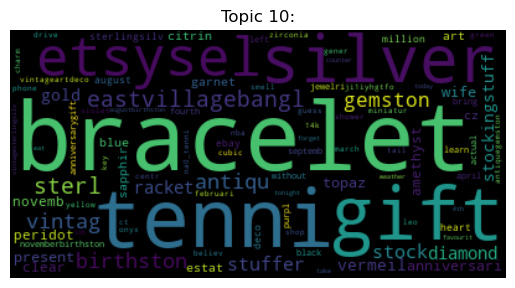

In [ ]:
# Display the wordclouds
display_word_crowd(lda_model, feature_names)

TODO
When having only a view subjects then the main ones are the record of coral cover/growth that was reached and the global climate change. These two topics can always be identified. Also, the subject around Palmer Clive appears already with a few topics (for example 5).

When one lets LDA split the data into more topics (for example 10) the "global climate change" subject splits up into people arguing with the coral cover of the GBR for and against human-made climate change. In the against subtopic the words "scientist", "lie", "told", "remember" appear often. Also, the "record of coral cover" subject splits up into subtopics around the "recovering" around the "comeback" around "record" and around "cover".

With an increasing number of topics, the location of the GBR ("australia", "queensland") and the aspects of tourism, traveling and diving come up. Also, the words "CNBC" and "news" build up a subject pointing to the global news about the GBR. The topic around Palmer Clive gets further specified to his coal mine near the GBR.

Increasing the number of subject even further (up to 15 for example) the data gets hard to overlook, as many topics which belong together are forced to split up into multiple topics. For example, the subject around Palmer Clive's coal mine is then split into one topic around a coal mine and a second one around Palmer Clive where those belong together as Palmer Clive is the owner of the coal mine near the GBR.

Some names are mentioned often around certain topics:
1. For Clive Palmer's coal mine at the GBR, this is [Clive Palmer](https://en.wikipedia.org/wiki/Clive_Palmer) himself
2. For news, this is the GB reporter [Sophie Corcoran](https://twitter.com/sophielouisecc)
3. For people arguing against the existence of (human-made) climate change, this is [PeterDClack](https://twitter.com/PeterDClack) and [BjornLomborg](https://twitter.com/BjornLomborg).

Note that the subjects of this part of the analysis match the word and hashtag count analysis results. Therewith I come to the following conclusion for this report.

## Conclusion - TODO
In this report, it is summarized, what the Great Barrier Reef is, what topics one might expect to hear on Twitter about it and which methods were used for downloading, pre-processing, and analyzing the tweets. Also, a short overview of the methods used and why those methods were used are provided. The results and conclusions which can be derived from the (visualized) data are further explained.

The report shows, that there is in general a positive sentiment towards the Great Barrier Reef. There is a peak when the news that the Great Barrier Reef is recovering, was released. The main question in the beginning, what the Great Barrier Reef is about on Twitter, got answered in this report:

There are several smaller subjects in the analyzed timeframe of Twitter posts about the Great Barrier Reef, such as Clive Palmer's coal mine or some tourism-related topics. The biggest topics were the news that the Great Barrier Reef is recovering and about a discussion on the existence of climate change, which emerged from that.